## Методы text-similarity ##

https://www.quora.com/What-are-the-most-popular-text-similarity-algorithms

1. doc2vec + cosine measure https://code.google.com/archive/p/word2vec/ 
<br>
    GloVe + cosine https://nlp.stanford.edu/projects/glove/
   <br>
   https://github.com/v1shwa/document-similarity
2. Jaccard similarity 
<br>
    https://en.wikipedia.org/wiki/Jaccard_index
<br>
    https://nickgrattan.wordpress.com/2014/02/18/jaccard-similarity-index-for-measuring-document-similarity/
3. Locality-sensitive hashing  
    https://en.wikipedia.org/wiki/Locality-sensitive_hashing 
<br>
    https://github.com/kayzhu/LSHash
<br>
    http://www.mmds.org/
4. Cosine Similarity and IDF Modified Cosine Similarity https://www.youtube.com/watch?v=C3Jt14Se9Cg&feature=youtu.be
<br>
<br>
* cosine similarity in gensim: https://radimrehurek.com/gensim/similarities/docsim.html
<br>
<br>
https://stackoverflow.com/questions/35758612/most-efficient-way-to-construct-similarity-matrix
<br>
<br>
https://ematosevic.wordpress.com/2016/08/21/clustering-data-with-similarity-matrix-in-python-tutorial/

### Articles data

In [1]:
#import sys
#sys.path.append('C:\Program Files\Anaconda3\Lib\site-packages')

In [4]:
import pandas as pd
import re
import sklearn
import numpy as np

#from nltk.corpus import stopwords
#stopwords_rus = stopwords.words('russian')

from stop_words import get_stop_words
stopwords = get_stop_words('russian')

from tqdm import tqdm

import networkx as nx

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

### Read preprocessed articles

In [6]:
articles_df = pd.read_csv('articles_lemm_meta.tsv', sep = '\t', encoding = 'utf-8')

### TFIDF cosine similarity

In [7]:
articles_df.shape

(30611, 13)

In [9]:
articles_good_rubrics = articles_df[articles_df.final_rubrics != 'Мусор']
articles_good_rubrics.shape

(24611, 13)

In [10]:
articles_good_rubrics = articles_good_rubrics.reset_index(drop = True)

### Load cosine matrix

In [7]:
cosine_matr = np.load('cosine_matr.npy')

In [24]:
cosine_matr.mean()

0.01952574045479845

In [52]:
num_texts = cosine_matr.shape[0]
mask = np.ones((num_texts,num_texts)) 
mask = (mask - np.diag(np.ones(num_texts))).astype(np.bool)

### Cos DataFrame

In [26]:
cos_df = pd.read_csv('cos_similar_texts.tsv', sep = '\t', encoding = 'utf-8')

In [76]:
cos_df.head(10)

,text1,text2,similarity,rubric_text1,rubric_text2
0,2,809,0.723853,Физиология человека,Биология
1,12,18521,0.702258,Физиология человека,Биология
2,17,4920,0.714982,Биология,Биология
3,26,4025,0.751949,Космос,Космос
4,26,5697,0.711348,Космос,Космос
5,26,16703,0.700656,Космос,Космос
6,26,18819,0.733729,Космос,Космос
7,26,19480,0.776776,Космос,Физика
8,26,23124,0.718873,Космос,Космос
9,38,6581,0.715665,Футурология,Computer Science


In [27]:
cos_links = cos_df[cos_df.text1 < cos_df.text2]

In [28]:
edges = pd.DataFrame({'source' : cos_links.text1.values,
                      'target' : cos_links.text2.values,
                      'weight' : cos_links.similarity.values})

In [29]:
g = nx.DiGraph()

# open csv edgelist and read edges into graph
for index, row in edges.iterrows():
    g.add_edge(row['source'], row['target'], weight = row['weight'])

pos = nx.spring_layout(g)

# draw network without node color
#nx.draw(g, pos, with_labels=False, node_size=25, arrows = False)

In [30]:
texts = list(cos_links.text1.values) + list(cos_links.text2.values)
rubrics = list(cos_links.rubric_text1.values) + list(cos_links.rubric_text2)
texts_rubrics = list(zip(texts, rubrics))
texts_rubrics = list(set(texts_rubrics))

texts, rubrics = zip(*texts_rubrics)

nodes = pd.DataFrame({'node' : texts,
                      'rubric' : rubrics})

In [26]:
set(articles_good_rubrics.final_rubrics)

{'Computer Science',
 'Биология',
 'История',
 'Космос',
 'Культура',
 'Математика',
 'Науки о земле',
 'Политология',
 'Психология',
 'Социология',
 'Технологии',
 'Физика',
 'Физиология человека',
 'Философия',
 'Футурология',
 'Химия',
 'Экономика',
 'Язык'}

In [35]:
rubric_colors = {
    'Computer Science':'blue',
    'Биология':'red',
    'История':'green',
    'Космос':'orange',
    'Культура':'teal',
    'Математика':'grey',
    'Науки о земле':'purple',
    'Политология':'brown',
    'Психология':'black',
    'Социология':'magenta',
    'Технологии':'cyan',
    'Физиология человека':'yellow',
    'Химия':'lightgreen',
    'Физика':'olive',
    'Философия':'maroon',
    'Футурология':'violet',
    'Экономика':'lightblue',
    'Язык':'greenyellow'
}

In [78]:
"""rubric_colors = {
    'Computer Science':'blue',
    'Биология':'red',
    'История':'green',
    'Космос':'yellow',
    'Культура':'orange',
    'Математика':'grey',
    'Науки о земле':'pink',
    'Политология':'brown',
    'Психология':'black',
    'Социология':'magenta',
    'Технологии':'cyan',
    'Физиология человека':'darkblue',
    'Химия':'lightgreen',
    'Физика':'crimson',
    'Философия':'darkorange',
    'Футурология':'greenyellow',
    'Экономика':'lightblue',
    'Язык':'violet'
}"""

In [32]:
rubric_attribute = []
for index, row in nodes.iterrows():
    rubric_attribute.append((row['node'], row['rubric']))
    
rubric_dictionary = dict(rubric_attribute)

nx.set_node_attributes(g, rubric_dictionary, "rubric")

In [33]:
node_col = []

for node in g.nodes(data=True):
    rubr_attr = node[1]['rubric']
    node_col.append(rubric_colors[rubr_attr])
    #print(node[1]['rubric'])

### Science graphs

In [11]:
def science_graph(df, science, rubric_colors_map):
    sci_df = df[(df.rubric_text1 == science)|(df.rubric_text2 == science)]
    
    edges = pd.DataFrame({'source' : sci_df.text1.values,
                      'target' : sci_df.text2.values,
                      'weight' : sci_df.similarity.values})
    
    texts = list(sci_df.text1.values) + list(sci_df.text2.values)
    rubrics = list(sci_df.rubric_text1.values) + list(sci_df.rubric_text2)
    texts_rubrics = list(zip(texts, rubrics))
    texts_rubrics = list(set(texts_rubrics))

    texts, rubrics = zip(*texts_rubrics)

    nodes = pd.DataFrame({'node' : texts,
                          'rubric' : rubrics})
    
    g = nx.Graph()

    # open csv edgelist and read edges into graph
    for index, row in edges.iterrows():
        g.add_edge(row['source'], row['target'], weight = row['weight'])

    #pos = nx.spring_layout(g)
    
    rubric_attribute = []
    for index, row in nodes.iterrows():
        rubric_attribute.append((row['node'], row['rubric']))

    rubric_dictionary = dict(rubric_attribute)

    nx.set_node_attributes(g, rubric_dictionary, "rubric")
    
    node_col = []

    for node in g.nodes(data=True):
        rubr_attr = node[1]['rubric']
        node_col.append(rubric_colors_map[rubr_attr])
        
    plt.figure(figsize=(10, 10))
    nx.draw(g, with_labels = False, node_size=25, node_color=node_col)
    #plt.legend(list(rubric_colors_map.values()), list(rubric_colors_map.keys()))
    #nx.draw_spring(g, with_labels=False, node_size=25, node_color=node_col_05, arrows = False)
    
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rubric_colors_map.values()]
    plt.legend(markers, rubric_colors_map.keys(), numpoints=1, loc=9, bbox_to_anchor=(1.1, 0.3))
    
    plt.show()
    
    return g

#nx.write_gexf(g, 'cos_graph.gexf')

In [8]:
cos_05_df = pd.read_csv('cos_05_similarity.tsv', sep = '\t', encoding = 'utf-8')

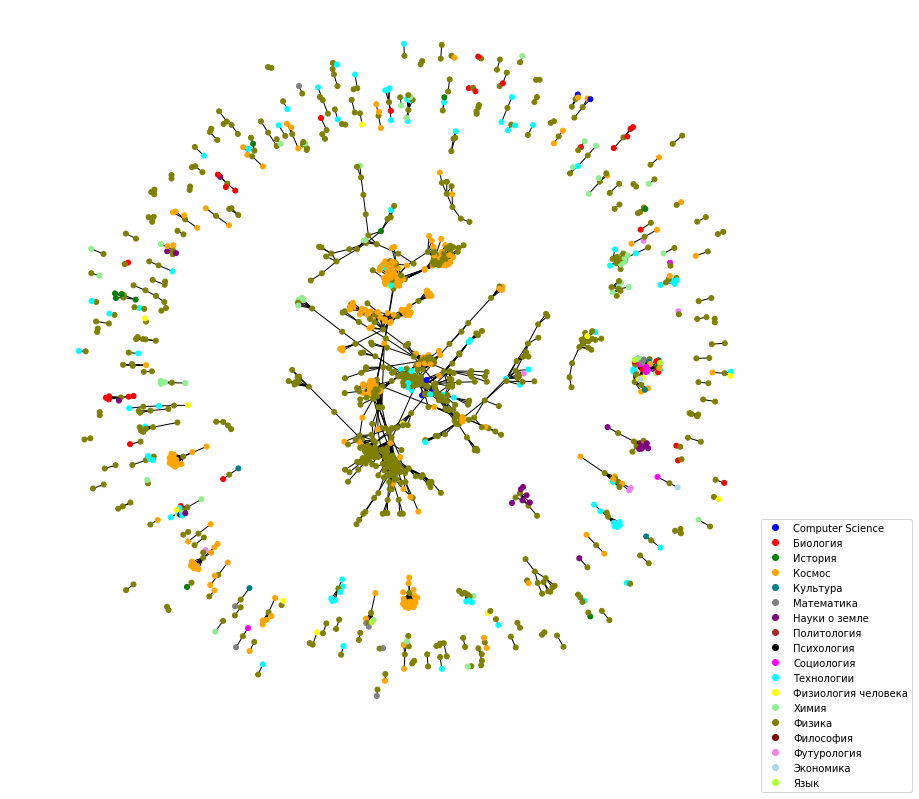

In [36]:
g_physics = science_graph(cos_05_df, 'Физика', rubric_colors)

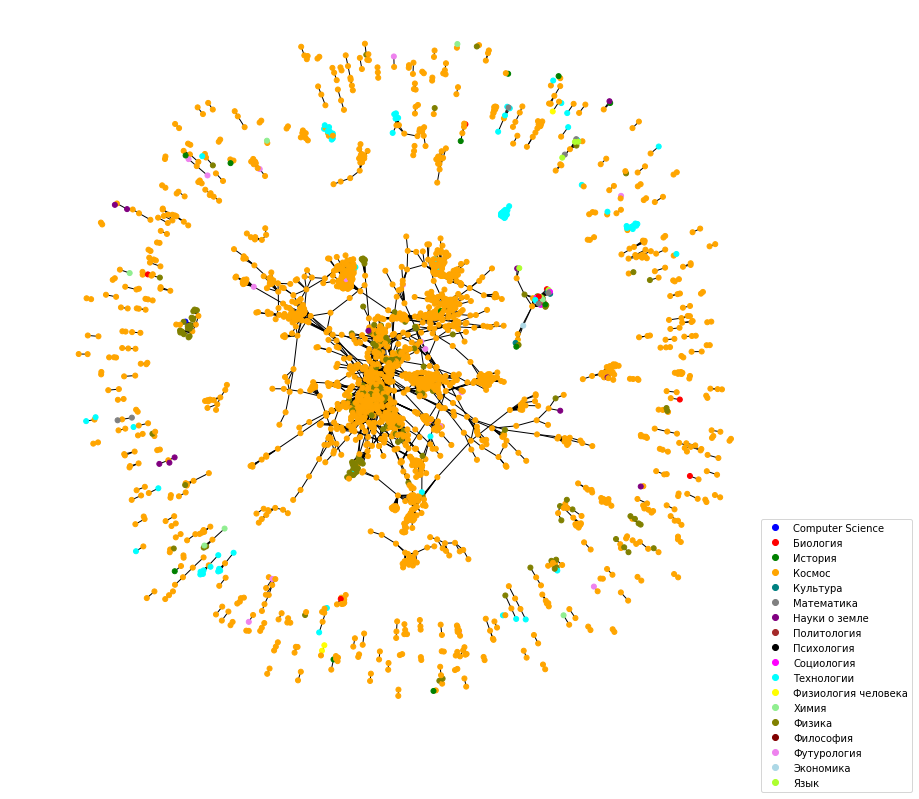

In [37]:
g_cosm = science_graph(cos_05_df, 'Космос', rubric_colors)

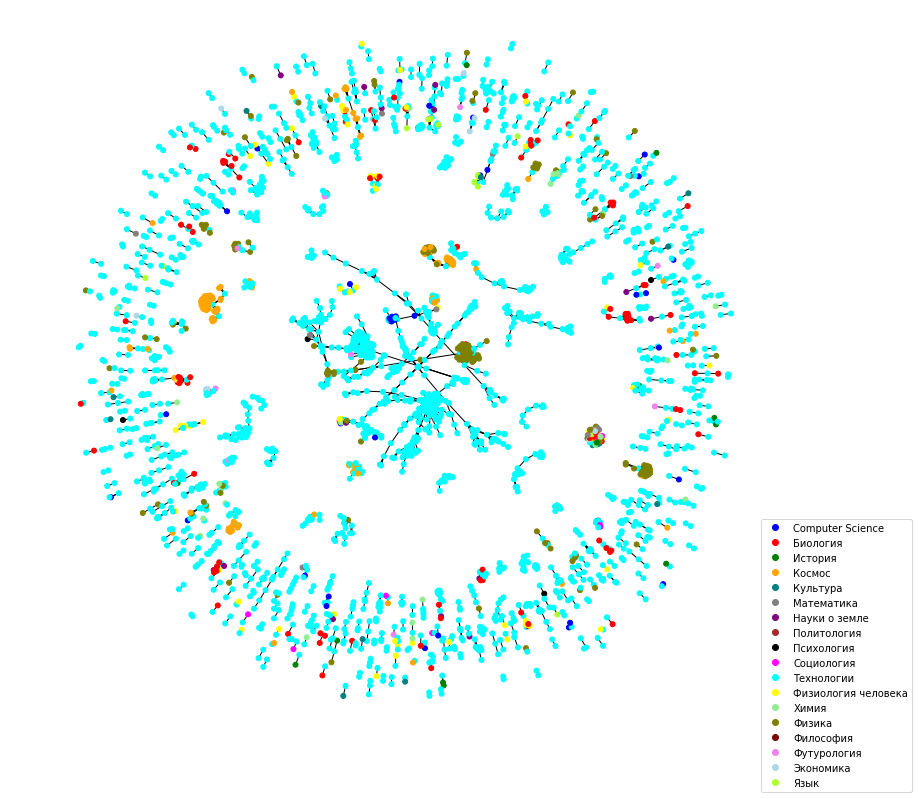

In [39]:
g_tech = science_graph(cos_05_df, 'Технологии', rubric_colors)

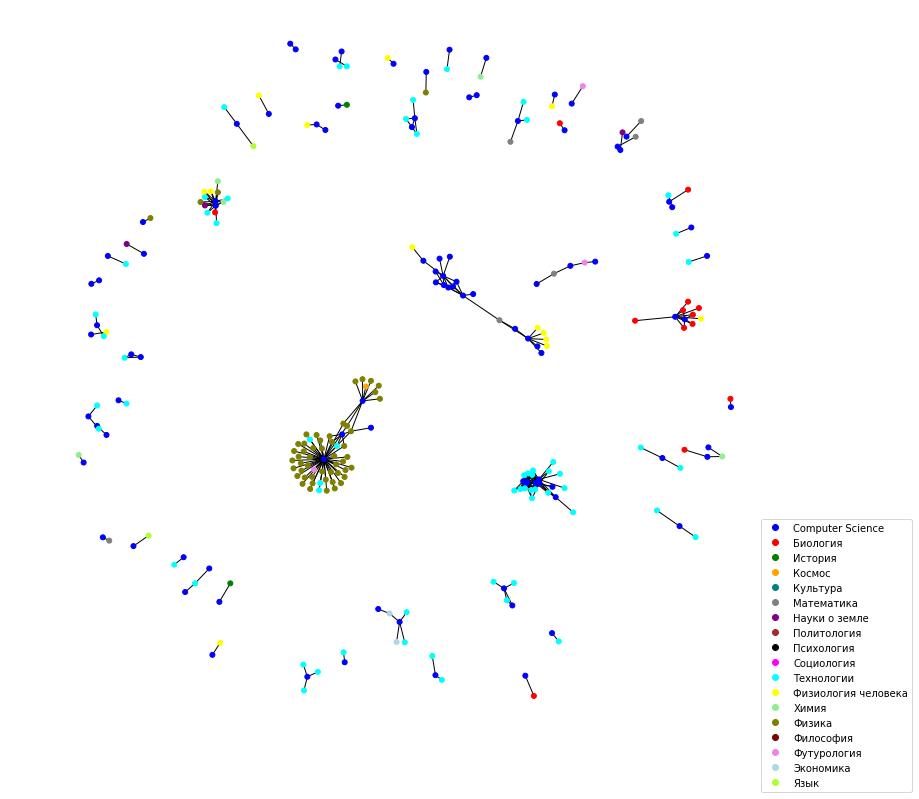

In [44]:
g_comp = science_graph(cos_05_df, 'Computer Science', rubric_colors)

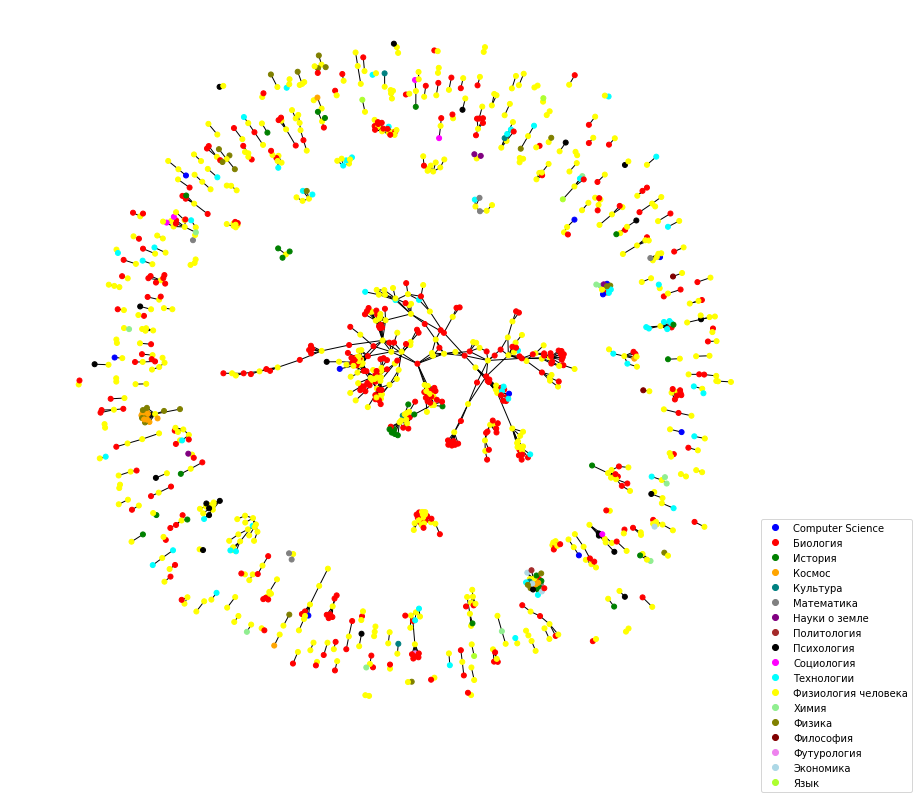

In [38]:
g_physiol = science_graph(cos_05_df, 'Физиология человека', rubric_colors)

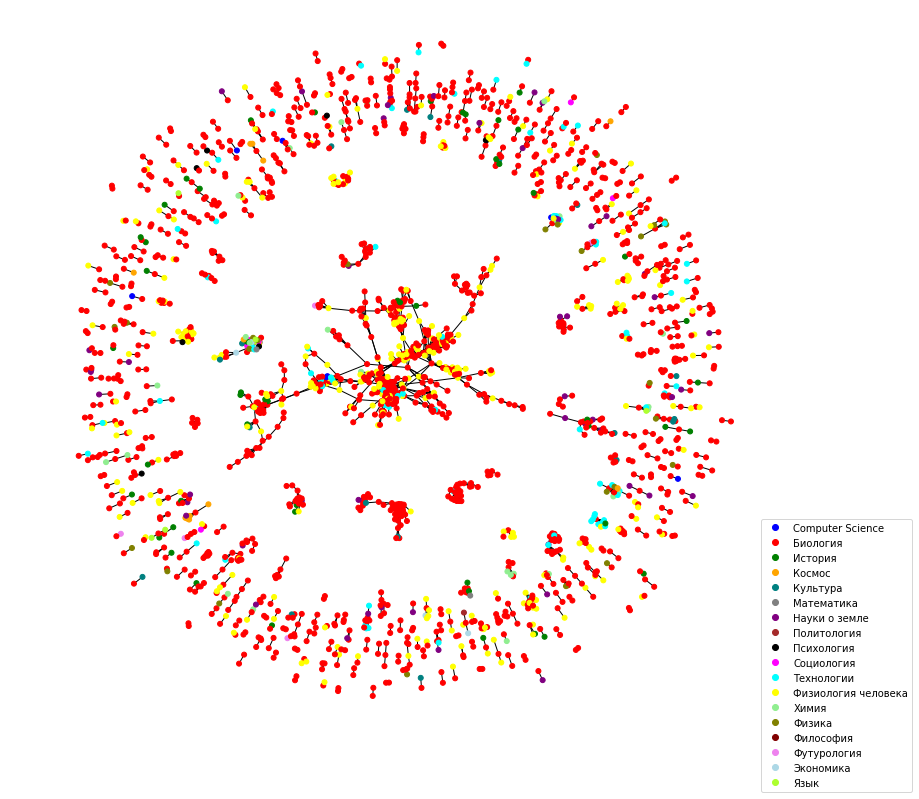

In [40]:
g_bio = science_graph(cos_05_df, 'Биология', rubric_colors)

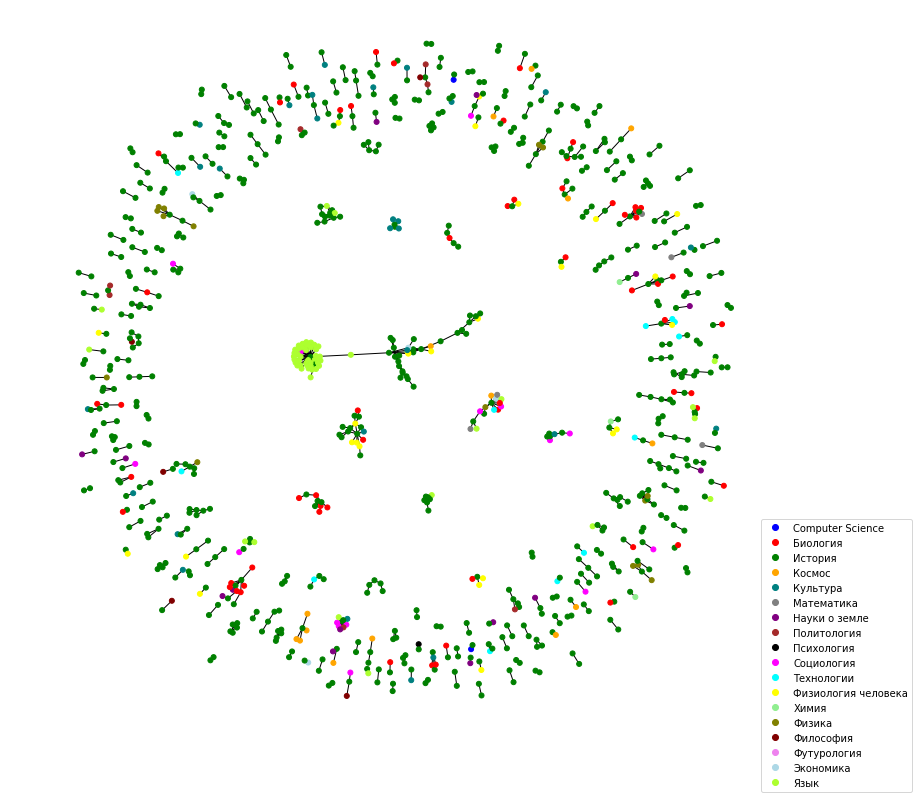

In [41]:
g_hist = science_graph(cos_05_df, 'История', rubric_colors)

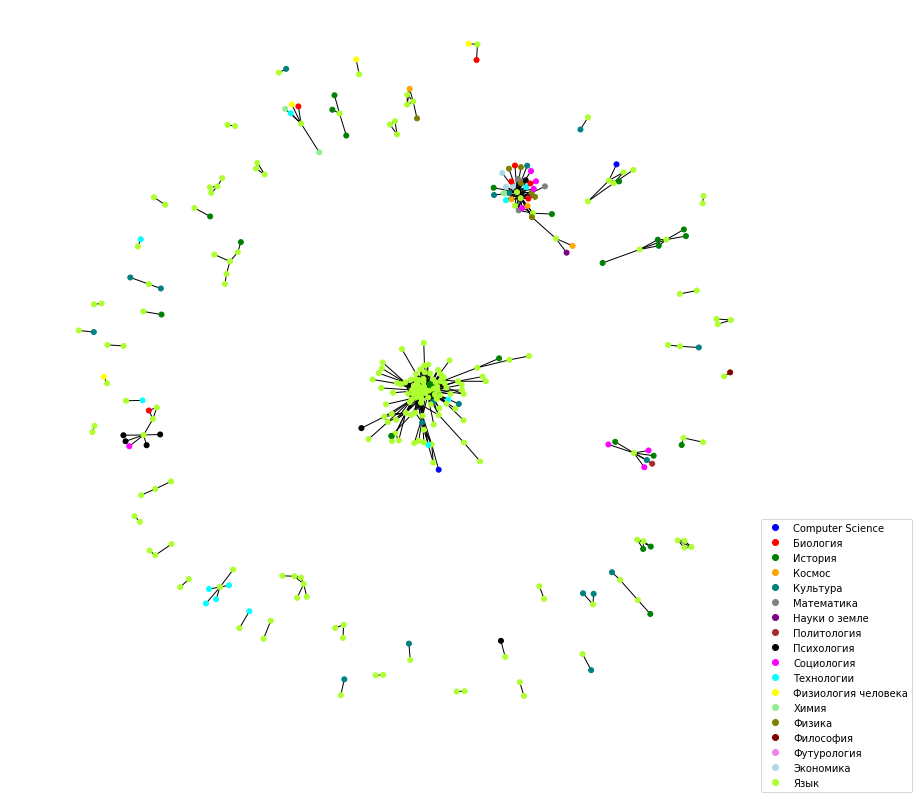

In [42]:
g_lang = science_graph(cos_05_df, 'Язык', rubric_colors)

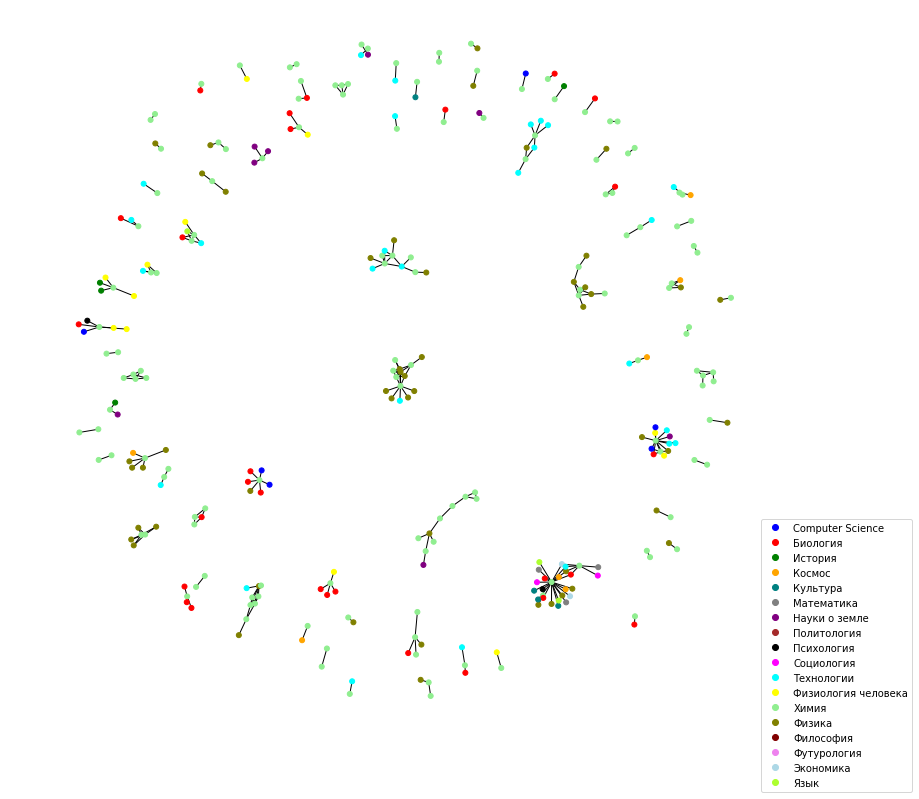

In [43]:
g_chem = science_graph(cos_05_df, 'Химия', rubric_colors)

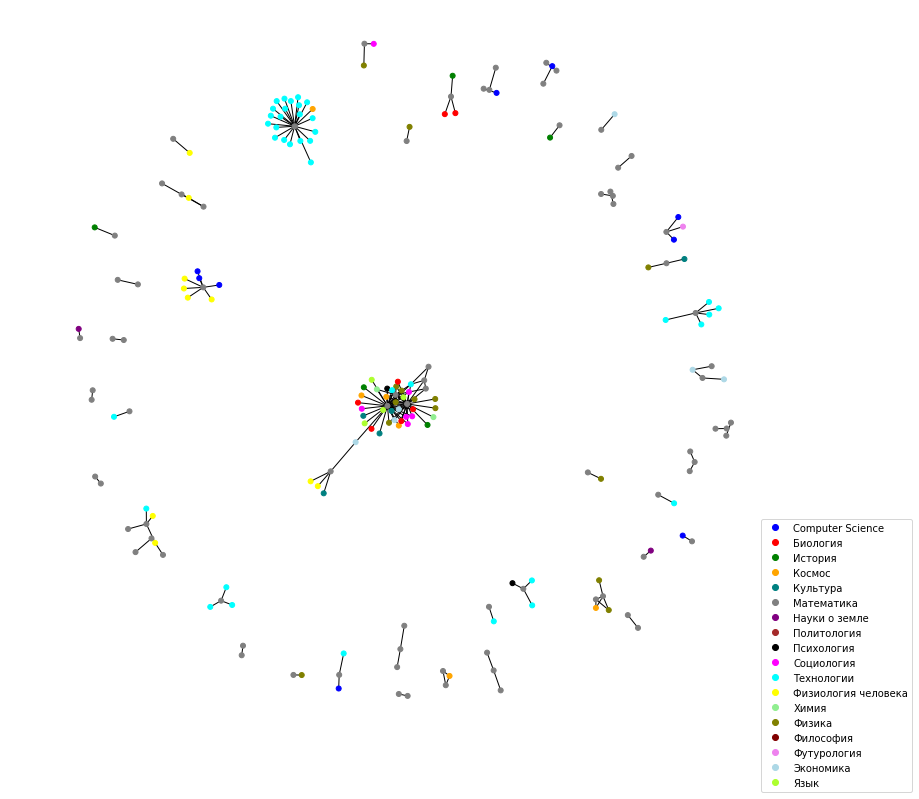

In [45]:
g_mat = science_graph(cos_05_df, 'Математика', rubric_colors)

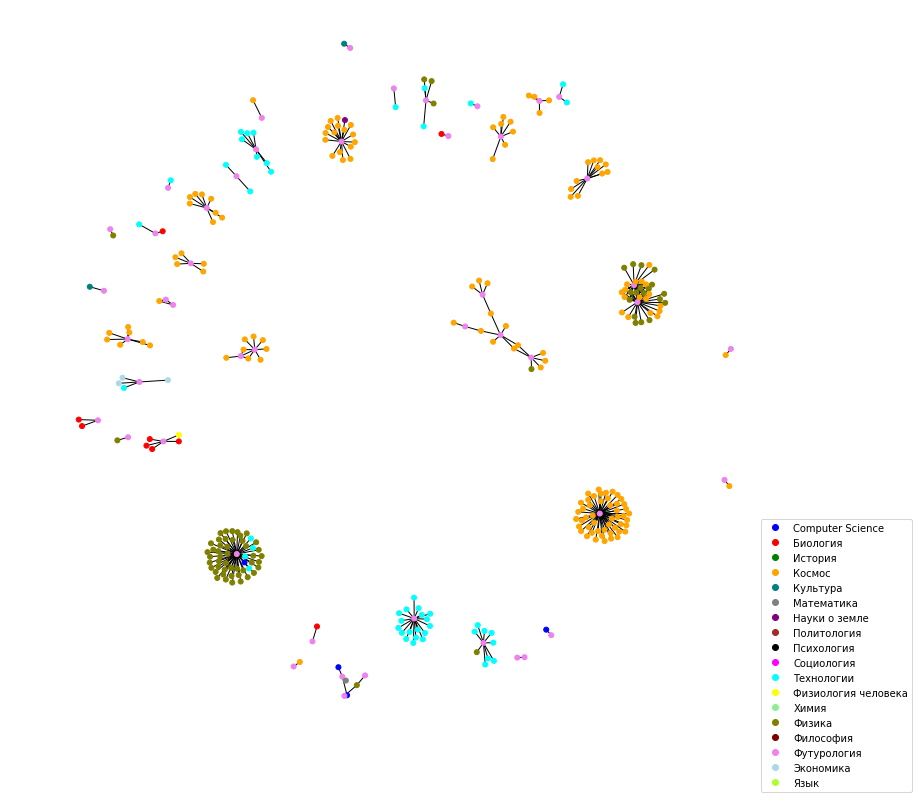

In [46]:
g_futur = science_graph(cos_05_df, 'Футурология', rubric_colors)

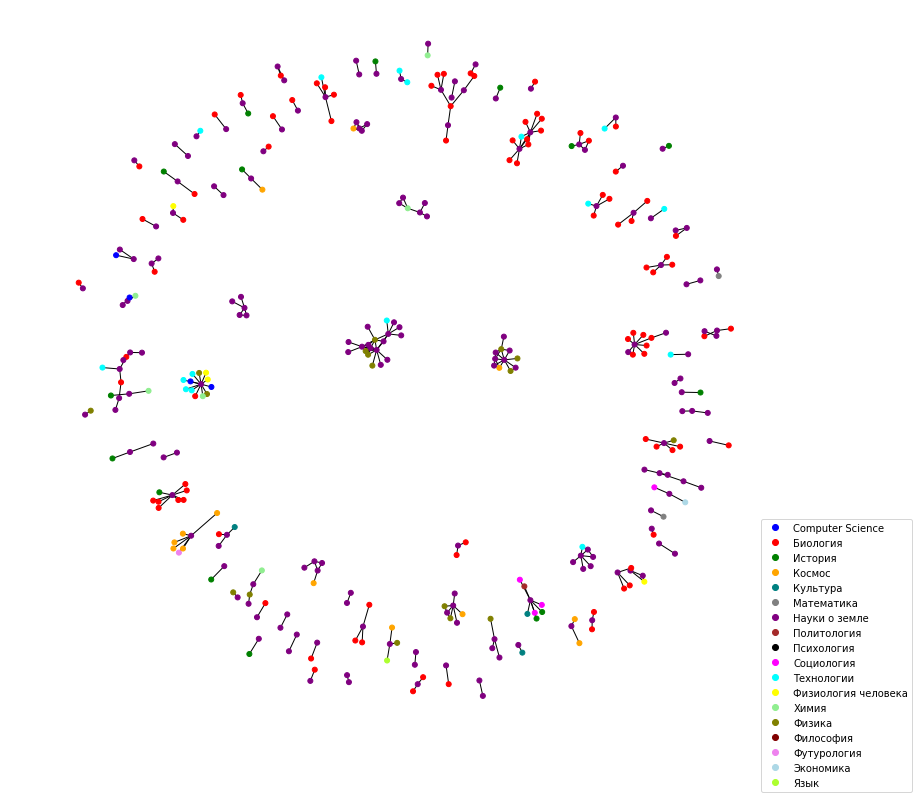

In [47]:
g_psych = science_graph(cos_05_df, 'Науки о земле', rubric_colors)

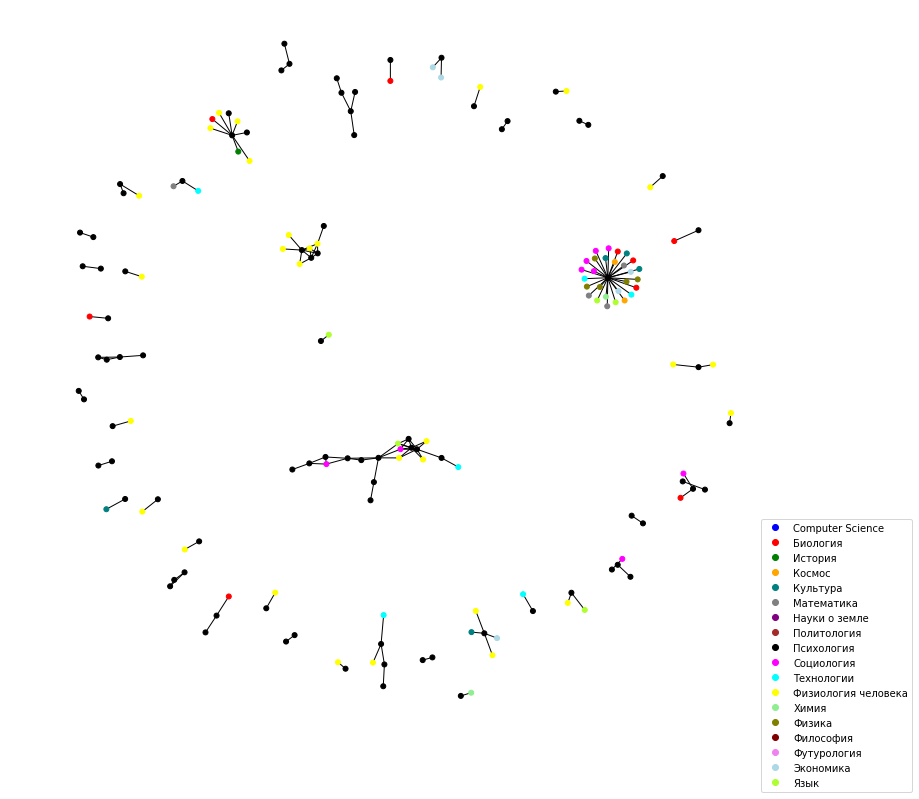

In [48]:
g_psych = science_graph(cos_05_df, 'Психология', rubric_colors)

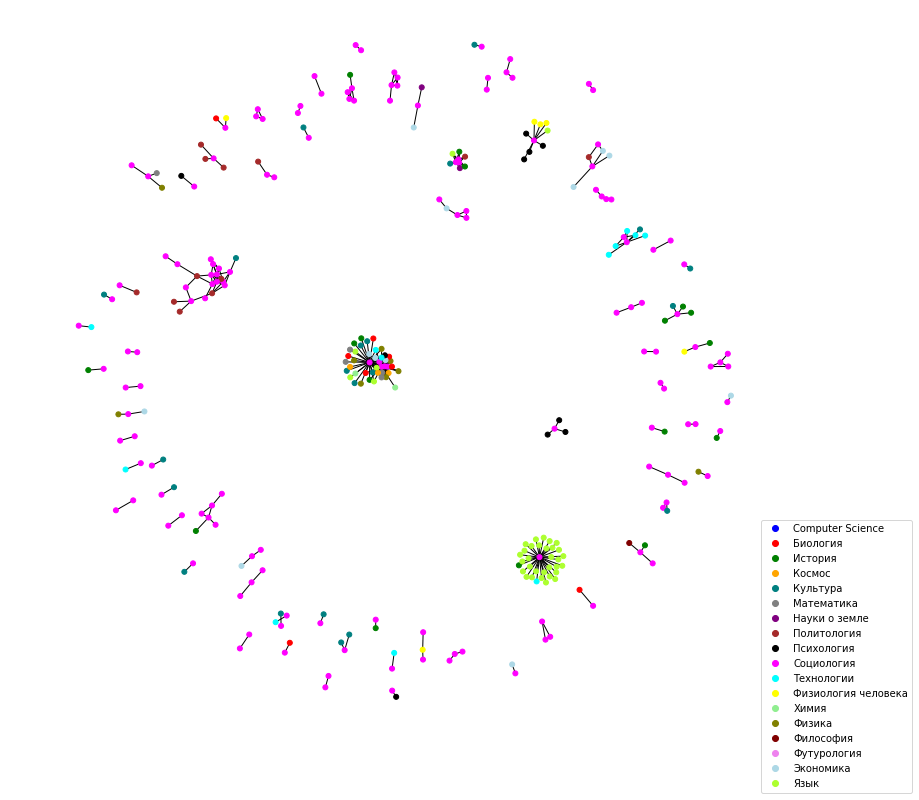

In [56]:
g_socio = science_graph(cos_05_df, 'Социология', rubric_colors)

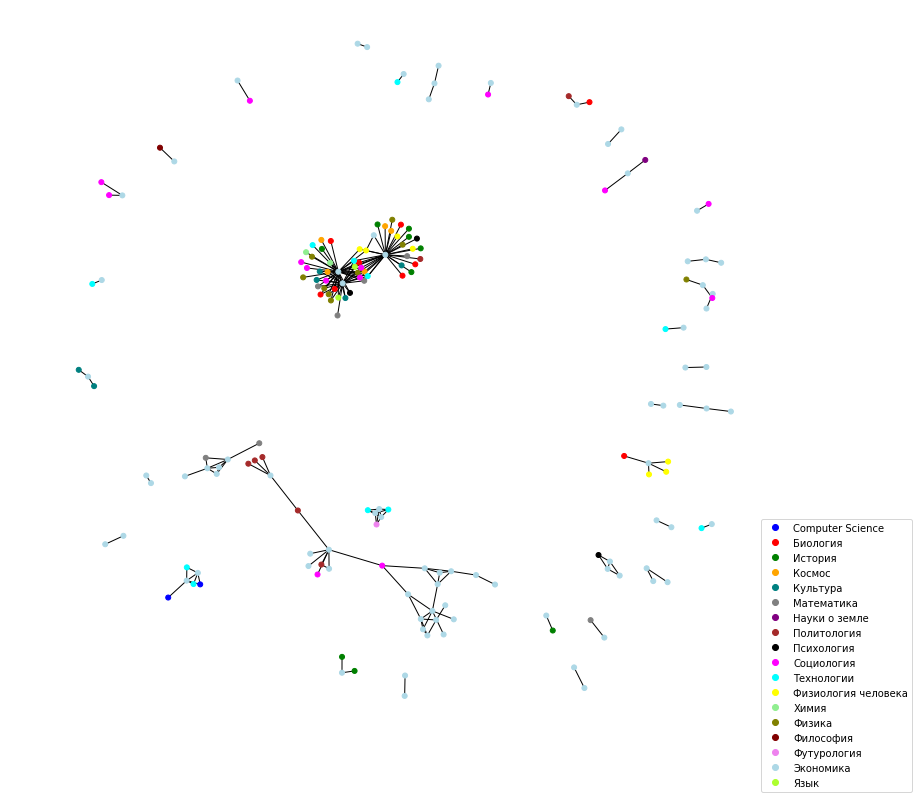

In [54]:
g_econ = science_graph(cos_05_df, 'Экономика', rubric_colors)

In [61]:
import functools
def disjunction(*conditions):
    return functools.reduce(np.logical_or, conditions)

In [67]:
def conjunction(*conditions):
    return functools.reduce(np.logical_and, conditions)

In [68]:
#nat_sci = ['Биология', 'Физиология человека', 'Психология','Науки о земле', 'Химия','Физика']

c1 = cos_05_df.rubric_text1 == 'Биология'
c2 = cos_05_df.rubric_text1 == 'Физиология человека'
c3 = cos_05_df.rubric_text1 == 'Психология'
c4 = cos_05_df.rubric_text1 == 'Науки о земле'
c5 = cos_05_df.rubric_text2 == 'Биология'
c6 = cos_05_df.rubric_text2 == 'Физиология человека'
c7 = cos_05_df.rubric_text2 == 'Психология'
c8 = cos_05_df.rubric_text2 == 'Науки о земле'

cos_nat = cos_05_df[conjunction(disjunction(c1,c2,c3,c4),disjunction(c5,c6,c7,c8))]

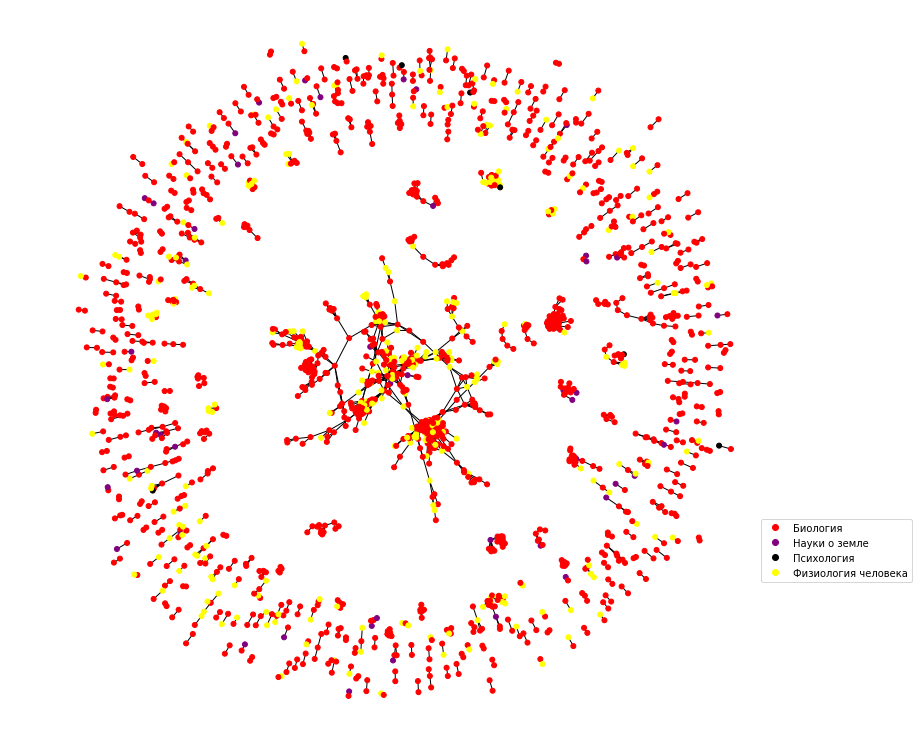

In [69]:
nat_sci_colors = {
    'Биология':'red',
    'Науки о земле':'purple',
    'Психология':'black',
    'Физиология человека':'yellow',
}

g_nat = science_graph(cos_nat, 'Биология', nat_sci_colors)

In [71]:
c1 = cos_05_df.rubric_text1 == 'Биология'
c2 = cos_05_df.rubric_text1 == 'История'
c3 = cos_05_df.rubric_text1 == 'Физика'
c4 = cos_05_df.rubric_text1 == 'Computer Science'
c5 = cos_05_df.rubric_text1 == 'Технологии'
c6 = cos_05_df.rubric_text2 == 'Биология'
c7 = cos_05_df.rubric_text2 == 'История'
c8 = cos_05_df.rubric_text2 == 'Физика'
c9 = cos_05_df.rubric_text2 == 'Computer Science'
c10 = cos_05_df.rubric_text2 == 'Технологии'

cos_bio_contr = cos_05_df[conjunction(disjunction(c1,c2,c3,c4,c5),disjunction(c9,c6,c7,c8,c10))]

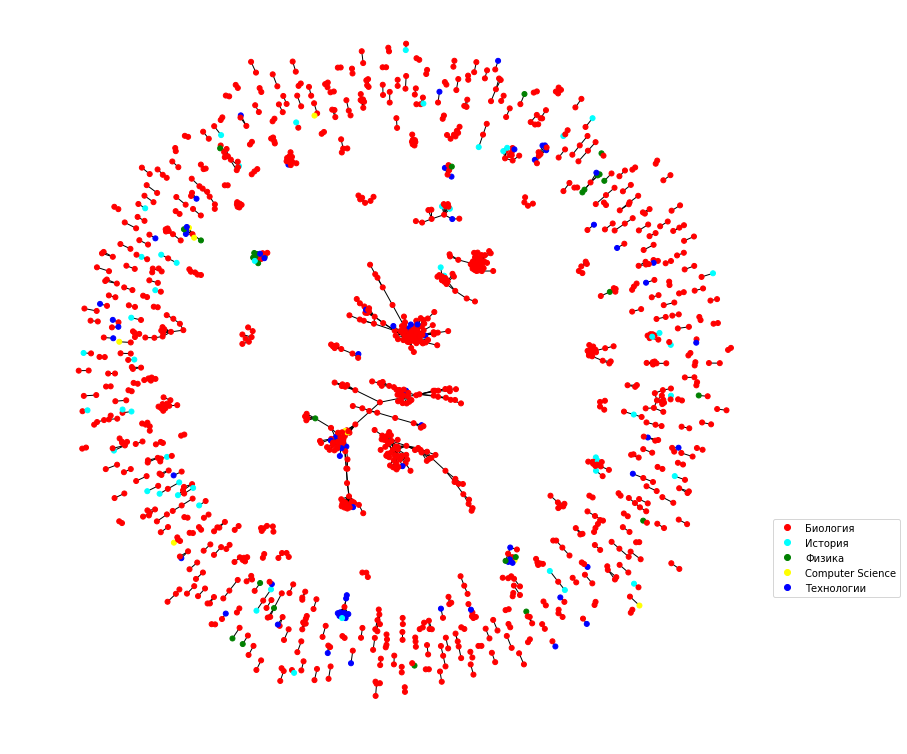

In [73]:
bio_contr_colors = {
    'Биология':'red',
    'История':'cyan',
    'Физика':'green',
    'Computer Science':'yellow',
    'Технологии':'blue'
}

g_nat = science_graph(cos_bio_contr, 'Биология', bio_contr_colors)

## Graph Characteristics

In [28]:
g.number_of_edges()

2245

In [7]:
#nodes sorted by degree
sorted(nx.degree(g), key = lambda x: x[1], reverse = True)[:20]

[('12451.0', 20),
 ('72.0', 19),
 ('12395.0', 18),
 ('4025.0', 17),
 ('24234.0', 17),
 ('12041.0', 17),
 ('19480.0', 16),
 ('3726.0', 16),
 ('15279.0', 15),
 ('7724.0', 15),
 ('10618.0', 14),
 ('15167.0', 14),
 ('10376.0', 14),
 ('13296.0', 14),
 ('12474.0', 14),
 ('24080.0', 13),
 ('10601.0', 13),
 ('174.0', 12),
 ('7862.0', 12),
 ('10464.0', 12)]

### Highest degree nodes

In [88]:
#highest degree text
print(articles_good_rubrics.iloc[12451])

path                 nplus1.ru/nplus1_news/nplus1.ru-news-2017-03-2...
source                                                       nplus1.ru
url                         nplus1.ru/news/2017/03/29/falcon-is-coming
date                                                        2017-03-29
title                Первый повторный полет Falcon 9 назначен на 30...
subtitle                                                           NaN
author                                                Николай Воронцов
tags                                                          _Космос_
genre                                                          Новости
mapped_rubrics                                                  Космос
final_rubrics                                                   Космос
number_of_rubrics                                                  One
text                 посадка один ступень falcon миссия ces spacex ...
Name: 12451, dtype: object


In [93]:
for ngh in nx.all_neighbors(g, 12451):
    print(articles_good_rubrics.iloc[int(ngh)].url)
    print(articles_good_rubrics.iloc[int(ngh)].title)
    
    print(articles_good_rubrics.iloc[int(ngh)].text[:200])
    print('\n')

nplus1.ru/news/2016/05/06/second-time
SpaceX во второй раз посадила первую ступень Falcon 9 на баржу
spacex аэрокосмический компания spacex успешный доставка груз орбита посадить один ступень ракета falcon плавучий платформа запуск посадка наблюдать прямой эфир два успешный посадка один ступень falco


nplus1.ru/news/2016/05/10/second-landing
SpaceX показала посадку Falcon 9 под разными углами
spacex аэрокосмический компания spacex опубликовать видео успешный посадка один ступень ракета falcon плавучий платформа ролик показывать посадка один ступень три разный точка доступный просмотр youtu


nplus1.ru/news/2016/06/08/this-fall-rocket-shall-not-fall
SpaceX запланировала повторный запуск первой ступени Falcon 9 на осень
четыре успешно сесть один ступень falcon spacex flickr аэрокосмический компания spacex запланировать повторный запуск использоваться один ступень falcon осень сообщить свой твиттер илона маск глава sp


nplus1.ru/news/2016/08/31/ses-launch
SpaceX нашла груз для первого п

In [94]:
for ngh in nx.all_neighbors(g, 72):
    print(articles_good_rubrics.iloc[int(ngh)].url)
    print(articles_good_rubrics.iloc[int(ngh)].title)
    
    print(articles_good_rubrics.iloc[int(ngh)].text[:200])
    print('\n')

https://chrdk.ru/sci/cp-symmetry_violation
Несимметричные нейтрино
учёный удаться обнаружить намёк нарушение сравнить симметрия эксперимент нейтрино возможно результат позволить объяснить вселенная вещество антивещество чердак рассказать завотдел физика высокий энерг


https://chrdk.ru/sci/kak_otkrytie_massy_neitrino_mozhet_obyasnit_sushhestvovanie_vselennoi
Антивещество, темная материя и новая физика
физика получить два престижный премия открытие масса нейтрино один нобелёвка открытие помочь объяснить вселенная материя антиматерия чердак рассказать завотдел физика высокий энергия институт ядерный 


https://chrdk.ru/sci/nobelevku_po_fizike_prisudili_za_dokazatelstvo_ostsiliatsij_neitrino
Свергнуть старую физику
нобелевский премия физиология медицина присудить сугубо практический исследование спасти жизнь сотня человек противовес физический нобель достаться учёный заниматься сверхфундаментальный вещь пытаться


https://chrdk.ru/news/arkticheskiy_detektor_poka_ne_obnaruzhil_sterilnoe_ne

## Save graph

In [59]:
nx.write_gexf(g, 'cos_graph.gexf')

In [69]:
nx.write_gml(g,'cos_graph_gml')

In [6]:
g = nx.read_gexf('cos_graph.gexf')

## Graph for Rubrics Similarity

In [12]:
cosine_matr.shape

(24611, 24611)

In [21]:
cos_matr_triu = np.triu(cosine_matr, k=0)

* При пороговом значении для близости cos_sim = 0.5:

In [23]:
cos_measures_triu = []
i, j = np.where((cos_matr_triu > 0.5)&(cos_matr_triu < 0.999))
for i_num, j_num in zip(i,j):
 #   if i_num > j_num:
    cos_measures_triu.append(cos_matr_triu[i_num][j_num])
print(len(i))

24387


In [33]:
print(articles_good_rubrics.iloc[464].text[:300])
print('\n')
print(articles_good_rubrics.iloc[24458].text[:300])

американский биолог продемонстрировать применение антибиотик пчела резко сокращать количество полезный бактерия кишечник ухудшать иммунитет повышать смертность сокращение количество пчела мир признаваться проблема глобальный уровень удивительно пчела опылять сельскохозяйственный растение сша пчела п


современный медоносный пчела страдать многочисленный угроза самый серьёзный распространение паразитический клещ варроа деструктор varroa des ruc or латинский название означать разрушитель получить гибельный действие пчелиный семья клещ варроа размножаться пчелиный улей плоский тело размер миллиметр 


### Full cos similarity df

In [54]:
cos_measures_triu = []
i, j = np.where((cos_matr_triu > 0.5)&(cos_matr_triu < 0.999))
for i_num, j_num in zip(i,j):
 #   if i_num > j_num:
    cos_measures_triu.append(cos_matr_triu[i_num][j_num])
print(len(i))

24387


In [24]:
cos_05_df = pd.DataFrame({'text1':i, 'text2':j, 'similarity':cos_measures_triu})
cos_05_df = cos_05_df[['text1', 'text2', 'similarity']]

In [25]:
cos_05_df[cos_05_df.similarity < 0.7].head()

,text1,text2,similarity
1,2,913,0.561699
2,2,5074,0.663363
3,2,12999,0.592937
4,2,14760,0.526159
5,2,16037,0.669185


In [26]:
rubric_map = dict(zip(articles_good_rubrics.index, articles_good_rubrics.final_rubrics))

In [27]:
cos_05_df = cos_05_df.assign(rubric_text1 = pd.Series([rubric_map[text1_ind] for text1_ind in cos_05_df.text1]).values)
cos_05_df = cos_05_df.assign(rubric_text2 = pd.Series([rubric_map[text2_ind] for text2_ind in cos_05_df.text2]).values)

In [28]:
cos_05_df.head()

,text1,text2,similarity,rubric_text1,rubric_text2
0,2,809,0.723853,Физиология человека,Биология
1,2,913,0.561699,Физиология человека,Биология
2,2,5074,0.663363,Физиология человека,Биология
3,2,12999,0.592937,Физиология человека,Физиология человека
4,2,14760,0.526159,Физиология человека,Биология


In [29]:
cos_05_df.to_csv('cos_05_similarity.tsv', sep = '\t', index = False, encoding = 'utf-8')

In [13]:
cos_05_df = pd.read_csv('cos_05_similarity.tsv', sep = '\t', encoding = 'utf-8')

In [16]:
edges_05 = pd.DataFrame({'source' : cos_05_df.text1.values,
                      'target' : cos_05_df.text2.values,
                      'weight' : cos_05_df.similarity.values})

In [17]:
texts = list(cos_05_df.text1.values) + list(cos_05_df.text2.values)
rubrics = list(cos_05_df.rubric_text1.values) + list(cos_05_df.rubric_text2)
texts_rubrics = list(zip(texts, rubrics))
texts_rubrics = list(set(texts_rubrics))

texts, rubrics = zip(*texts_rubrics)

nodes_05 = pd.DataFrame({'node' : texts,
                      'rubric' : rubrics})

In [21]:
g_05 = nx.DiGraph()

# open csv edgelist and read edges into graph
for index, row in edges_05.iterrows():
    g_05.add_edge(row['source'], row['target'], weight = row['weight'])

#pos = nx.spring_layout(g_05)

# draw network without node color
#nx.draw(g, pos, with_labels=False, node_size=25, arrows = False)

In [23]:
rubric_attribute_05 = []
for index, row in nodes_05.iterrows():
    rubric_attribute_05.append((row['node'], row['rubric']))
    
rubric_dictionary_05 = dict(rubric_attribute_05)

nx.set_node_attributes(g_05, rubric_dictionary_05, "rubric")

In [24]:
node_col_05 = []

for node in g_05.nodes(data=True):
    rubr_attr = node[1]['rubric']
    node_col_05.append(rubric_colors[rubr_attr])
    #print(node[1]['rubric'])

In [ ]:
#plt.figure(figsize=(15, 15))

#nx.draw_spring(g_05, with_labels=False, node_size=25, node_color=node_col_05, arrows = False)
#plt.show()

In [60]:
nx.write_gexf(g_05, 'cos_graph_05.gexf')

In [30]:
cos_05_df.groupby(['rubric_text1', 'rubric_text2']).size().sort_values(ascending = False)

rubric_text1         rubric_text2       
Космос               Космос                 9976
Технологии           Технологии             3523
Физика               Физика                 2187
Биология             Биология               1689
Космос               Физика                  697
Язык                 Язык                    587
Физика               Космос                  484
Физиология человека  Физиология человека     448
Биология             Физиология человека     388
История              История                 384
Физиология человека  Биология                362
Технологии           Космос                  265
                     Физика                  162
Футурология          Космос                  156
Физика               Технологии              143
Культура             Культура                133
Космос               Технологии              121
Социология           Социология              103
Технологии           Биология                 92
Науки о земле        Науки о

In [18]:
rubric_combinations_df = cos_05_df.groupby(['rubric_text1', 'rubric_text2']).size().to_frame(name = 'count').reset_index()

In [33]:
rubric_combinations_df.head(20)

,rubric_text1,rubric_text2,count
0,Computer Science,Computer Science,52
1,Computer Science,Биология,10
2,Computer Science,История,2
3,Computer Science,Математика,9
4,Computer Science,Науки о земле,3
5,Computer Science,Технологии,42
6,Computer Science,Физика,39
7,Computer Science,Физиология человека,12
8,Computer Science,Химия,4
9,Computer Science,Экономика,3


In [34]:
rubric_combinations_df.to_csv('rubrics_couples.tsv', sep = '\t', index = False, encoding = 'utf-8')

In [9]:
rubric_volume = dict(articles_good_rubrics.groupby(['final_rubrics']).size())
rubric_volume

{'Computer Science': 421,
 'Биология': 4049,
 'История': 2257,
 'Космос': 4323,
 'Культура': 699,
 'Математика': 249,
 'Науки о земле': 575,
 'Политология': 55,
 'Психология': 380,
 'Социология': 464,
 'Технологии': 5773,
 'Физика': 1969,
 'Физиология человека': 1802,
 'Философия': 142,
 'Футурология': 188,
 'Химия': 506,
 'Экономика': 232,
 'Язык': 527}

In [12]:
cos_05_aggr = cos_05_df.groupby(['rubric_text1', 'rubric_text2'], as_index = False).agg({'similarity': ['count','sum']})

In [13]:
cos_05_aggr.reset_index(inplace = True)

In [15]:
cos_05_aggr.head()

index      rubric_text1      rubric_text2 similarity           
                                                 count        sum
0     0  Computer Science  Computer Science         52  30.630509
1     1  Computer Science          Биология         10   5.675495
2     2  Computer Science           История          2   1.028802
3     3  Computer Science        Математика          9   5.382747
4     4  Computer Science     Науки о земле          3   2.042601

In [16]:
#dictionary - rubric_couple:count
def make_rubric_dict(rubr_df):
    rubric_couples_dict = {}
    for index, row in rubr_df.iterrows():
        rubr_couple = ('|').join(sorted((row['rubric_text1'], row['rubric_text2'])))
        rubric_couples_dict.setdefault(rubr_couple, 0)
        rubric_couples_dict[rubr_couple] += row['count']
    return rubric_couples_dict
        

In [19]:
rubric_couples_dict = make_rubric_dict(rubric_combinations_df)

In [20]:
len(rubric_couples_dict)

144

In [21]:
rubric_couples_df = pd.DataFrame(list(rubric_couples_dict.items()), columns = ['couple', 'count'])

In [22]:
rubric_couples_df['rubric_text1'], rubric_couples_df['rubric_text2'] = rubric_couples_df['couple'].str.split('|',1).str
rubric_couples_df.pop('couple')

0            Computer Science|Computer Science
1                    Computer Science|Биология
2                     Computer Science|История
3                  Computer Science|Математика
4               Computer Science|Науки о земле
5                  Computer Science|Технологии
6                      Computer Science|Физика
7         Computer Science|Физиология человека
8                       Computer Science|Химия
9                   Computer Science|Экономика
10                       Computer Science|Язык
11                           Биология|Биология
12                            Биология|История
13                             Биология|Космос
14                           Биология|Культура
15                         Биология|Математика
16                      Биология|Науки о земле
17                         Биология|Психология
18                         Биология|Социология
19                         Биология|Технологии
20                             Биология|Физика
21           

In [90]:
rubr_count_df = articles_good_rubrics.groupby(['final_rubrics']).size().to_frame(name = 'rubr_count').reset_index()

In [91]:
rubr_count_df

,final_rubrics,rubr_count
0,Computer Science,421
1,Биология,4049
2,История,2257
3,Космос,4323
4,Культура,699
5,Математика,249
6,Науки о земле,575
7,Политология,55
8,Психология,380
9,Социология,464


In [23]:
rubr_count_dict = articles_good_rubrics.groupby(['final_rubrics']).size().to_dict()

In [24]:
rubr_count_dict

{'Computer Science': 421,
 'Биология': 4049,
 'История': 2257,
 'Космос': 4323,
 'Культура': 699,
 'Математика': 249,
 'Науки о земле': 575,
 'Политология': 55,
 'Психология': 380,
 'Социология': 464,
 'Технологии': 5773,
 'Физика': 1969,
 'Физиология человека': 1802,
 'Философия': 142,
 'Футурология': 188,
 'Химия': 506,
 'Экономика': 232,
 'Язык': 527}

In [25]:
rubric_similarity = []
for index, row in rubric_couples_df.iterrows():
    rubr_sim = row['count']*10000/(rubr_count_dict[row['rubric_text1']]*rubr_count_dict[row['rubric_text2']])
    rubric_similarity.append(rubr_sim)

In [27]:
rubric_couples_df['rubrics_similarity'] = rubric_similarity

In [29]:
rubric_couples_df.to_csv('rubric_couples_similarity.tsv', sep = '\t', encoding = 'utf-8', index = False)

In [74]:
rubric_couples_sim = pd.read_csv('rubric_couples_similarity.tsv', sep = '\t', encoding='utf-8')

In [75]:
rubric_couples_sim.head()

,count,rubric_text1,rubric_text2,rubrics_similarity
0,52,Computer Science,Computer Science,2.933858
1,18,Computer Science,Биология,0.105595
2,2,Computer Science,История,0.021048
3,9,Computer Science,Математика,0.858541
4,4,Computer Science,Науки о земле,0.165238


In [76]:
edges_rubr = pd.DataFrame({'source' : rubric_couples_sim.rubric_text1.values,
                      'target' : rubric_couples_sim.rubric_text2.values,
                      'weight' : rubric_couples_sim.rubrics_similarity.values})

In [77]:
g_rubr = nx.DiGraph()

# open csv edgelist and read edges into graph
for index, row in edges_rubr.iterrows():
    g_rubr.add_edge(row['source'], row['target'], weight = row['weight'])

pos = nx.spring_layout(g_rubr)

# draw network without node color
#nx.draw(g_rubr, pos, with_labels=False, node_size=25, arrows = False)

In [84]:
rubric_colors = {
    'Computer Science':'blue',
    'Биология':'red',
    'История':'green',
    'Космос':'yellow',
    'Культура':'orange',
    'Математика':'grey',
    'Науки о земле':'pink',
    'Политология':'brown',
    'Психология':'lightgrey',
    'Социология':'magenta',
    'Технологии':'cyan',
    'Физиология человека':'darkblue',
    'Химия':'lightgreen',
    'Физика':'crimson',
    'Философия':'darkorange',
    'Футурология':'greenyellow',
    'Экономика':'lightblue',
    'Язык':'violet'
}

In [85]:
node_rubr_col = []

for node in g_rubr.nodes(data=True):
    node_rubr_col.append(rubric_colors[node[0]])
    #print(node[0])

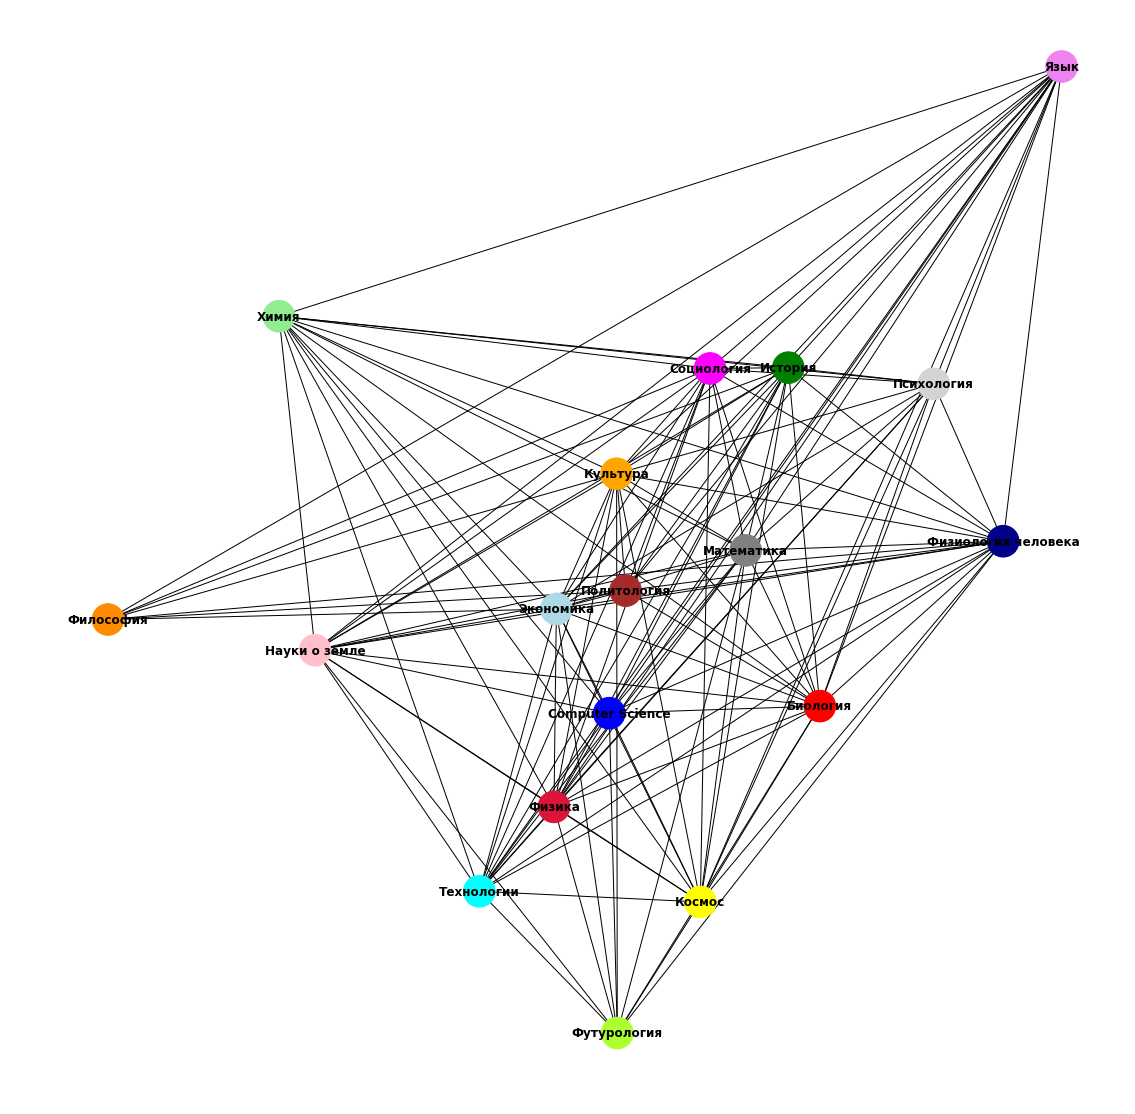

In [92]:
plt.figure(figsize=(15, 15))
nx.draw(g_rubr, pos, with_labels=True, node_size=1000, node_color=node_rubr_col, arrows = False, font_weight = 'bold')
plt.show()

In [63]:
rubric_couples_sim.sort_values(by = 'rubrics_similarity', ascending=False)

,count,rubric_text1,rubric_text2,rubrics_similarity
83,24,Политология,Политология,79.338843
143,587,Язык,Язык,21.135711
141,59,Экономика,Экономика,10.961653
84,25,Политология,Социология,9.796238
125,18,Философия,Философия,8.926800
86,9,Политология,Экономика,7.053292
113,2187,Физика,Физика,5.641016
39,9976,Космос,Космос,5.338091
64,33,Математика,Математика,5.322495
97,103,Социология,Социология,4.784111


In [67]:
rubric_couples_sim.describe()

,count,rubrics_similarity
count,144.000000,144.000000
mean,169.354167,1.514014
std,910.384807,6.971393
min,1.000000,0.005495
25%,4.000000,0.079912
50%,12.000000,0.192629
75%,36.250000,0.755365
max,9976.000000,79.338843


In [70]:
rubric_couples_sim[(rubric_couples_sim.rubric_text1 != rubric_couples_sim.rubric_text2) & (rubric_couples_sim.rubrics_similarity > 0.4)].sort_values(by = 'rubrics_similarity', ascending = False)

,count,rubric_text1,rubric_text2,rubrics_similarity
84,25,Политология,Социология,9.796238
86,9,Политология,Экономика,7.053292
115,80,Физика,Футурология,2.161158
48,167,Космос,Футурология,2.054818
103,21,Социология,Экономика,1.950803
71,11,Математика,Экономика,1.904168
104,43,Социология,Язык,1.758490
46,1181,Космос,Физика,1.387455
85,1,Политология,Философия,1.280410
66,12,Математика,Социология,1.038637


In [101]:
e_strong=[(u,v) for (u,v,d) in g_rubr.edges(data=True) if d['weight'] > 0.4]
e_weak=[(u,v) for (u,v,d) in g_rubr.edges(data=True) if d['weight'] <= 0.4]

In [102]:
pos = nx.spring_layout(g_rubr)

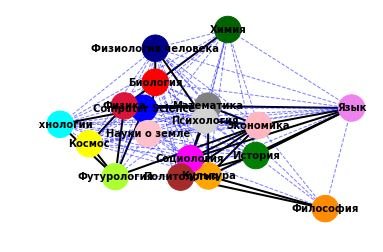

In [106]:

nx.draw_networkx_nodes(g_rubr, pos, node_size=700, node_color=node_rubr_col)

nx.draw_networkx_edges(g_rubr,pos,edgelist=e_strong, width=2, arrows = False)
nx.draw_networkx_edges(g_rubr,pos,edgelist=e_weak, width=1,alpha=0.5,edge_color='b',style='dashed', arrows = False)

nx.draw_networkx_labels(g_rubr,pos,font_size=10,font_family='sans-serif', font_weight = 'bold')

plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display


In [81]:
import matplotlib.pyplot as plt

In [91]:
e_strong = []
e_weak = []

In [94]:
e_strong=[(u,v) for (u,v,d) in g_rubr.edges(data=True) if d['weight'] > 0.5]
e_weak=[(u,v) for (u,v,d) in g_rubr.edges(data=True) if d['weight'] <= 0.5]

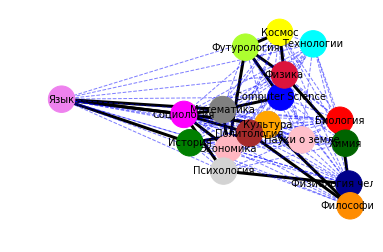

In [95]:
nx.draw_networkx_nodes(g_rubr, pos, node_size=700, node_color=node_rubr_col)

nx.draw_networkx_edges(g_rubr,pos,edgelist=e_strong, width=3, arrows = False)
nx.draw_networkx_edges(g_rubr,pos,edgelist=e_weak, width=1,alpha=0.5,edge_color='b',style='dashed', arrows = False)

nx.draw_networkx_labels(g_rubr,pos,font_size=10,font_family='sans-serif')

plt.axis('off')
plt.savefig("weighted_graph_05.png") # save as png
plt.show() # display
